In [ ]:
!pip install yfinance

In [ ]:
import pandas as pd
import datetime
from datetime import date
import yfinance as yf
from matplotlib import pyplot as plt
import keras
from keras.initializers import HeUniform
from keras.layers import Input, Dense
from keras.losses import Huber
from keras.optimizers import Adam
from keras.models import Sequential, Model
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from pickle import dump, load
import numpy as np
import random
from collections import deque
from IPython.display import clear_output
import os

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Aug 25 02:20:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Access more memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# See if Tensorflow is using GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_dir = f"{os.sep}content{os.sep}drive{os.sep}My Drive{os.sep}S&P 500 Stock Trading{os.sep}"

In [ ]:
ls "/content/drive/My Drive/S&P 500 Stock Trading/"

# Get S&P 500 Stock Data

In [ ]:
class Company:
  def __init__(self, symbol, name, stock):
    self.symbol = symbol
    self.name = name
    self.stock = stock

In [ ]:
symbols = []
names = []

In [ ]:
today = datetime.datetime.now()
print("Today is " + str(today.strftime("%b-%d-%Y")))
fifteen_years_ago = today - datetime.timedelta(days=15*365)
print("The day fifteen years ago was " + str(fifteen_years_ago.strftime("%b-%d-%Y")))

Today is Aug-25-2024
The day fifteen years ago was Aug-29-2009


In [ ]:
# Load the table
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]

# Check available columns
print(df.columns)

# Set the reference date to 15 years ago
fifteen_years_ago = datetime.datetime.now() - datetime.timedelta(days=15*365)

# Initialize lists to store the results
symbols = []
names = []

# Check if the 'Date first added' column exists
if 'Date added' in df.columns:
    for i in range(len(df)):
        if df.loc[i, "Symbol"] == "BF.B":  # Handle the 'BF.B' case
            continue
        date_first_added = df.loc[i, "Date added"]
        if not isinstance(date_first_added, str):
            continue
        # Parse and check the date
        date_first_added = datetime.datetime.strptime(date_first_added[:10], "%Y-%m-%d")
        if date_first_added > fifteen_years_ago:
            continue
        symbols.append(df.loc[i, "Symbol"])
        names.append(df.loc[i, "Security"])
else:
    print("The 'Date added' column is missing from the dataset.")

# Output the results
print(f"Symbols: {symbols}")
print(f"Names: {names}")

Index(['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry',
       'Headquarters Location', 'Date added', 'CIK', 'Founded'],
      dtype='object')
Symbols: ['MMM', 'ABT', 'ADBE', 'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALL', 'GOOG', 'MO', 'AMZN', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AMP', 'AMGN', 'APH', 'ADI', 'AON', 'APA', 'AAPL', 'AMAT', 'ADM', 'AIZ', 'T', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BBY', 'BIIB', 'BA', 'BSX', 'BMY', 'BXP', 'CHRW', 'CPB', 'COF', 'CAH', 'CCL', 'CAT', 'CBRE', 'COR', 'CNP', 'CF', 'SCHW', 'CVX', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'GLW', 'COST', 'CTRA', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DVA', 'DE', 'DVN', 'DFS', 'DOV', 'DHI', 'DTE', 'DUK', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EA', 'ELV', 'EMR', 'ETR', 'EOG', 'EFX', 'EQR', 'EL', 'ES', 'EXC', 'EXPE', 'EXPD', 'XOM', 'FAST', 'FDX', 'FIS', 'FITB', 'FE', 'FI', 'FMC', 'F', 'BEN', 'GE', 'GEN', 'GD', 'G

In [ ]:
print(len(symbols))
print(len(names))

276
276


In [ ]:
str_symbols = " ".join(symbols)

In [ ]:
data = yf.download(str_symbols, start=fifteen_years_ago, end=today)

[*********************100%%**********************]  276 of 276 completed


In [ ]:
data.head()

Price       Adj Close                                                        \
Ticker              A      AAPL        ABT       ADBE        ADI        ADM   
Date                                                                          
2009-08-31  16.478645  5.073184  15.531781  31.420000  19.885900  19.555456   
2009-09-01  16.587732  4.985420  15.494016  31.100000  19.540979  19.012819   
2009-09-02  16.183460  4.981799  15.452807  31.000000  19.400192  18.694012   
2009-09-03  16.228374  5.023118  15.473411  31.490000  19.815504  19.006029   
2009-09-04  16.594149  5.136521  15.669146  32.049999  20.273062  19.609718   

Price                                                   ...    Volume  \
Ticker            ADP       ADSK        AEE        AEP  ...       WFC   
Date                                                    ...             
2009-08-31  23.404160  23.430000  15.296683  17.497885  ...  35614100   
2009-09-01  23.056305  22.700001  15.308030  17.297461  ...  87353300   
2009-09-02  22.989161  22.760000  15.092504  17.141575  ...  53902400   
2009-09-03  23.074608  22.559999  15.228618  17.147146  ...  39465400   
2009-09-04  23.538416  23.120001  15.251304  17.252926  ...  31552900   

Price                                                                         \
Ticker           WM       WMB       WMT       WY     WYNN      XEL       XOM   
Date                                                                           
2009-08-31  1684200   7085132  51727800  1636500  3265000  2129700  24337900   
2009-09-01  2671900   6856354  49847100  2841600  5125600  2259600  24373900   
2009-09-02  2779700  12231722  40324200  1976600  3697500  2862500  16315800   
2009-09-03  2149700   6788763  48886800  2013300  2053700  2234400  15156000   
2009-09-04  1981300   3453631  39809700  1574900  3358100  1336700  15156600   

Price                         
Ticker          YUM      ZBH  
Date                          
2009-08-31  5299710  1827323  
2009-09-01  6177153  2337379  
2009-09-02  6405138  1861828  
2009-09-03  5925104  2614758  
2009-09-04  2693811  5429439  

[5 rows x 1656 columns]

In [ ]:
companies = []

In [ ]:
for i in range(len(symbols)):
  symbol = symbols[i]
  name = names[i]
  companies.append(Company(symbol, name, list(data["Close"][symbol][1:])))

In [ ]:
def plot_stock(symbol):
  for i in range(len(companies)):
    if companies[i].symbol == symbol:
      plt.plot(companies[i].stock)
      plt.title(companies[i].name + " Stock")
      plt.ylabel("Stock Price (USD)")
      plt.xlabel(f"Number of days (after {fifteen_years_ago.month}/{fifteen_years_ago.day}/{fifteen_years_ago.year})")
      plt.show()
      return
  print(symbol + " stock data not found")

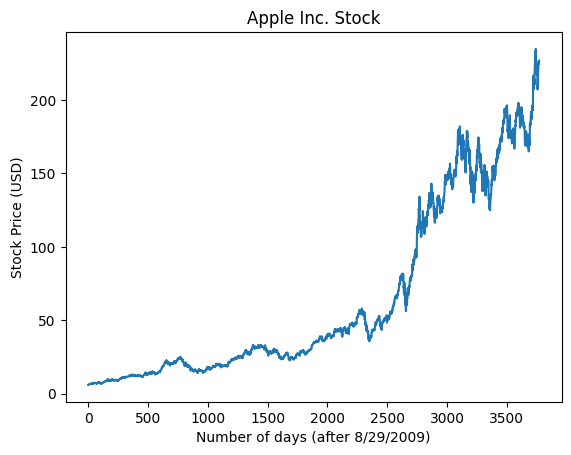

In [ ]:
plot_stock("AAPL")

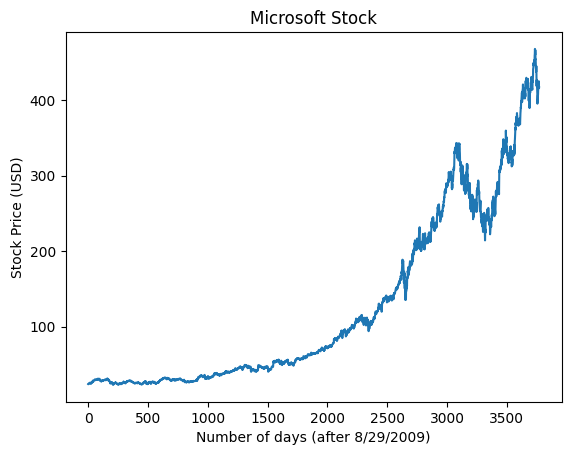

In [ ]:
plot_stock("MSFT")

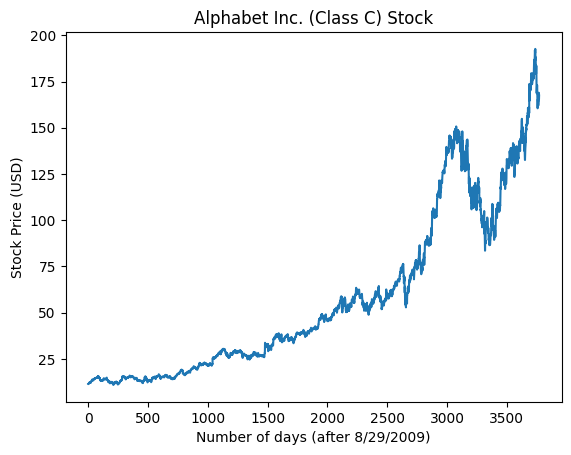

In [ ]:
plot_stock("GOOG")

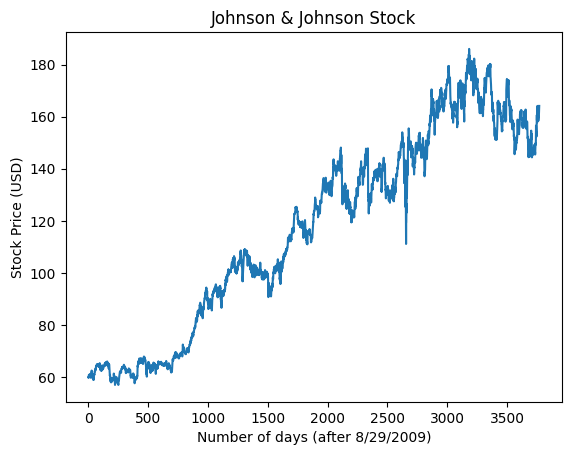

In [ ]:
plot_stock("JNJ")

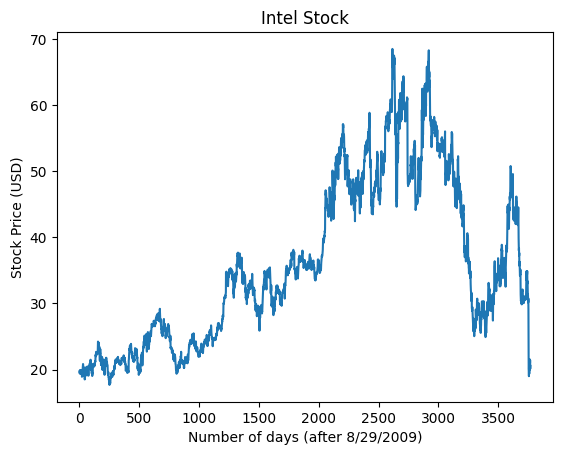

In [ ]:
plot_stock("INTC")

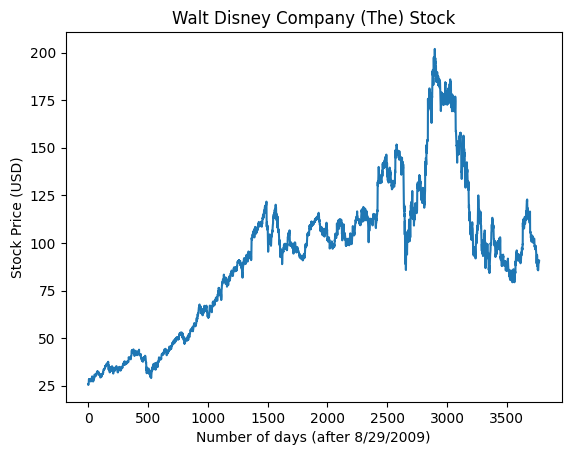

In [ ]:
plot_stock("DIS")

# Train Deep Q-Learning Model

In [ ]:
num_days_per_company = 30

In [ ]:
input_shape = num_days_per_company*len(companies)
print(input_shape)
output_shape = len(companies)
print(output_shape)

8280
276


In [ ]:
def make_model(layers=[100, 100, 100], # number of hidden layers and number of neurons for hidden layers
               input_shape=input_shape, # input shape of model
               output_shape=output_shape, # output shape of model
               lr=0.001, # learning rate
               kernel_initializer=HeUniform, # kernel initializer
               hidden_activation='relu', # activation function for hidden layers
               output_activation='linear', # activation function for output layer
               loss=Huber,
               optimizer=Adam,
               metrics='accuracy'
              ):
  if not isinstance(metrics, list):
    metrics = [metrics]
  input_layer = Input(shape=input_shape)
  model = input_layer
  for layer in layers:
    model = Dense(units=layer, activation=hidden_activation, kernel_initializer=kernel_initializer())(model)
  model = Dense(output_shape, activation=output_activation, kernel_initializer=kernel_initializer())(model)
  model = Model(input_layer, model)
  model.compile(loss=loss(), optimizer=optimizer(lr=lr), metrics=metrics)
  return model

In [ ]:
make_model().summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 8280)]            0         
                                                                 
 dense_16 (Dense)            (None, 100)               828100    
                                                                 
 dense_17 (Dense)            (None, 100)               10100     
                                                                 
 dense_18 (Dense)            (None, 100)               10100     
                                                                 
 dense_19 (Dense)            (None, 276)               27876     
                                                                 
Total params: 876176 (3.34 MB)
Trainable params: 876176 (3.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
x = []
y = []

In [ ]:
for i in range(num_days_per_company, len(companies[0].stock)):
  x_i = []
  y_i = []
  for j in range(len(companies)):
    x_i.extend(companies[j].stock[i-num_days_per_company:i])
    y_i.append(companies[j].stock[i])
  x.append(x_i)
  y.append(y_i)

In [ ]:
x = np.array(x)
y = np.array(y)

In [ ]:
print(x.shape)
print(y.shape)

(3740, 8280)
(3740, 276)


In [ ]:
np.save(drive_dir+"x.npy", x)
np.save(drive_dir+"y.npy", y)

In [ ]:
train_portion = 2.0/3.0
val_portion = 1.0/6.0
test_portion = 1.0/6.0

In [ ]:
train_idx = int(x.shape[0]*train_portion)
val_idx = int(x.shape[0]*val_portion)+train_idx
test_idx = x.shape[0]+1

In [ ]:
x_train = x[:train_idx]
x_val = x[train_idx:val_idx]
x_test = x[val_idx:test_idx]

In [ ]:
y_train = y[:train_idx]
y_val = y[train_idx:val_idx]
y_test = y[val_idx:test_idx]

In [ ]:
print(x_train.shape)
print(y_train.shape)

(2493, 8280)
(2493, 276)


In [ ]:
print(x_val.shape)
print(y_val.shape)

(623, 8280)
(623, 276)


In [ ]:
print(x_test.shape)
print(y_test.shape)

(624, 8280)
(624, 276)


In [ ]:
normalizer_x = Normalizer()
normalizer_y = Normalizer()

In [ ]:
x_train = normalizer_x.fit_transform(x_train)
y_train = normalizer_y.fit_transform(y_train)

x_val = normalizer_x.transform(x_val)
y_val = normalizer_y.transform(y_val)

x_test = normalizer_x.transform(x_test)
y_test = normalizer_y.transform(y_test)

In [ ]:
dump(normalizer_x, open(drive_dir+'normalizer_x.pkl', 'wb'))
dump(normalizer_y, open(drive_dir+'normalizer_y.pkl', 'wb'))

In [ ]:
np.save(drive_dir+"x_train.npy", x_train)
np.save(drive_dir+"y_train.npy", y_train)

np.save(drive_dir+"x_val.npy", x_val)
np.save(drive_dir+"y_val.npy", y_val)

np.save(drive_dir+"x_test.npy", x_test)
np.save(drive_dir+"y_test.npy", y_test)

In [ ]:
def get_q_values(model, stock):
  return model.predict(np.array([stock]))[0]

In [ ]:
def train(replay_memory, model, target_model, end, lr=0.7, discount=0.618, min_replay_size=1000, batch_size=128):

    if len(replay_memory) < min_replay_size:
        return

    mini_batch = random.sample(replay_memory, batch_size)
    current_states = np.array([transition[0] for transition in mini_batch])
    current_qs_list = model.predict(current_states)
    new_current_states = np.array([transition[3] for transition in mini_batch])
    future_qs_list = target_model.predict(new_current_states)

    X = []
    Y = []
    for index, (observation, action, reward, new_observation, end) in enumerate(mini_batch):
        if not end:
            max_future_q = reward + discount * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        current_qs = current_qs_list[index]
        current_qs[action] = (1 - lr) * current_qs[action] + lr * max_future_q

        X.append(observation)
        Y.append(current_qs)
    model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)

In [ ]:
def tanh(x):
  return (np.exp(2*x)-1)/(np.exp(2*x)+1)

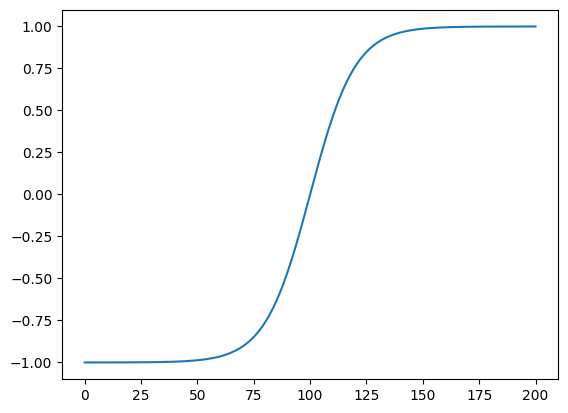

In [ ]:
plt.plot([tanh(0.05*i) for i in range(-100, 101)])

In [ ]:
def step(i, action, a=0.05):
  stock_price = x_train[i][num_days_per_company*action + num_days_per_company - 1]
  next_day_stock_price = y_train[i][action]
  diff = next_day_stock_price - stock_price
  percent_diff = diff/stock_price
  reward = tanh(a*percent_diff)
  done = False
  new_i = i+1
  if new_i >= x_train.shape[0]-1:
    done = True
  new_observation = x_train[new_i]
  return [new_i, new_observation, reward, done]

In [ ]:
def fit_model(
    layers=[100, 100, 100], # hidden layers for model
    train_episodes = 30,
    epsilon=1, # initial epsilon value
    max_epsilon=1, # maximum epsilon value
    min_epsilon=0.01, # minimum epsilon value
    decay = 0.01,
    update=4, # updates model every update steps
    target_update=100 # updates target_model every target_update steps
):

  model = make_model(layers=layers)
  target_model = make_model(layers=layers)
  target_model.set_weights(model.get_weights())

  replay_memory = deque(maxlen=50000)

  target_update_counter = 0

  X = []
  y = []

  steps = 0

  for episode in range(train_episodes):
      total_training_rewards = 0
      i = 0
      observation = x_train[i]
      done = False
      while not done:
          progress_bar = list('**********')
          for k in range(int(10*i/x_train.shape[0])):
            progress_bar[k] = '-'
          progress_bar = "".join(progress_bar)
          print(f"Episode {episode+1}/{train_episodes}: {i}/{x_train.shape[0]} {progress_bar[:5]}{round(100*i/x_train.shape[0], 2)}%{progress_bar[5:]}")
          steps += 1

          random_number = np.random.rand()
          if random_number <= epsilon:
              action = np.random.randint(len(companies))
          else:
              predicted = get_q_values(model, observation)
              action = np.argmax(predicted)
          new_i, new_observation, reward, done = step(i, action)
          replay_memory.append([observation, action, reward, new_observation, done])

          # 3. Update the Main Network using the Bellman Equation
          if steps % update == 0 or done:
              train(replay_memory, model, target_model, done)

          observation = new_observation
          i = new_i
          total_training_rewards += reward

          if done:
              print('Total training rewards: {} after n steps = {} with final reward = {}'.format(total_training_rewards, episode, reward))
              total_training_rewards += 1

              if steps >= 100:
                  print('Copying main network weights to the target network weights')
                  target_model.set_weights(model.get_weights())
                  steps = 0
              break

      epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
  return model, target_model

In [ ]:
models = []

In [ ]:
for i in range(1, 5): # number of 100 neuron hidden layers for model
  model, target_model = fit_model(layers=[100 for k in range(i)])
  model.save(drive_dir+f"model_{i}")
  models.append(model)

Streaming output truncated to the last 5000 lines.
Episode 29/30: 2117/2493 -----84.92%---**
Episode 29/30: 2118/2493 -----84.96%---**
1/1 [==============================] - 0s 20ms/step
Episode 29/30: 2119/2493 -----85.0%---**
4/4 [==============================] - 0s 2ms/step
Episode 29/30: 2120/2493 -----85.04%---**
Episode 29/30: 2121/2493 -----85.08%---**
Episode 29/30: 2122/2493 -----85.12%---**
Episode 29/30: 2123/2493 -----85.16%---**
4/4 [==============================] - 0s 2ms/step
Episode 29/30: 2124/2493 -----85.2%---**
Episode 29/30: 2125/2493 -----85.24%---**
1/1 [==============================] - 0s 19ms/step
Episode 29/30: 2126/2493 -----85.28%---**
Episode 29/30: 2127/2493 -----85.32%---**
4/4 [==============================] - 0s 2ms/step
Episode 29/30: 2128/2493 -----85.36%---**
1/1 [==============================] - 0s 21ms/step
Episode 29/30: 2129/2493 -----85.4%---**
1/1 [==============================] - 0s 19ms/step
Episode 29/30: 2130/2493 -----85.44%---**
Epi

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 19ms/step
Episode 29/30: 2118/2493 -----84.96%---**
Episode 29/30: 2119/2493 -----85.0%---**
4/4 [==============================] - 0s 2ms/step
Episode 29/30: 2120/2493 -----85.04%---**
1/1 [==============================] - 0s 20ms/step
Episode 29/30: 2121/2493 -----85.08%---**
Episode 29/30: 2122/2493 -----85.12%---**
Episode 29/30: 2123/2493 -----85.16%---**
4/4 [==============================] - 0s 2ms/step
Episode 29/30: 2124/2493 -----85.2%---**
Episode 29/30: 2125/2493 -----85.24%---**
Episode 29/30: 2126/2493 -----85.28%---**
Episode 29/30: 2127/2493 -----85.32%---**
4/4 [==============================] - 0s 2ms/step
Episode 29/30: 2128/2493 -----85.36%---**
Episode 29/30: 2129/2493 -----85.4%---**
1/1 [==============================] - 0s 20ms/step
Episode 29/30: 2130/2493 -----85.44%---**
1/1 [==============================] - 0s 19ms/step
Episode 29/30: 2131/2493 -----85.48%---**
4/4

Streaming output truncated to the last 5000 lines.
Episode 29/30: 2100/2493 -----84.24%---**
Episode 29/30: 2101/2493 -----84.28%---**
Episode 29/30: 2102/2493 -----84.32%---**
Episode 29/30: 2103/2493 -----84.36%---**
4/4 [==============================] - 0s 3ms/step
Episode 29/30: 2104/2493 -----84.4%---**
Episode 29/30: 2105/2493 -----84.44%---**
Episode 29/30: 2106/2493 -----84.48%---**
Episode 29/30: 2107/2493 -----84.52%---**
4/4 [==============================] - 0s 3ms/step
Episode 29/30: 2108/2493 -----84.56%---**
Episode 29/30: 2109/2493 -----84.6%---**
Episode 29/30: 2110/2493 -----84.64%---**
Episode 29/30: 2111/2493 -----84.68%---**
4/4 [==============================] - 0s 3ms/step
Episode 29/30: 2112/2493 -----84.72%---**
Episode 29/30: 2113/2493 -----84.76%---**
Episode 29/30: 2114/2493 -----84.8%---**
Episode 29/30: 2115/2493 -----84.84%---**
4/4 [==============================] - 0s 2ms/step
Episode 29/30: 2116/2493 -----84.88%---**
Episode 29/30: 2117/2493 -----84.9

Streaming output truncated to the last 5000 lines.
Episode 29/30: 2123/2493 -----85.16%---**
4/4 [==============================] - 0s 2ms/step
Episode 29/30: 2124/2493 -----85.2%---**
Episode 29/30: 2125/2493 -----85.24%---**
Episode 29/30: 2126/2493 -----85.28%---**
Episode 29/30: 2127/2493 -----85.32%---**
4/4 [==============================] - 0s 2ms/step
Episode 29/30: 2128/2493 -----85.36%---**
1/1 [==============================] - 0s 19ms/step
Episode 29/30: 2129/2493 -----85.4%---**
Episode 29/30: 2130/2493 -----85.44%---**
1/1 [==============================] - 0s 20ms/step
Episode 29/30: 2131/2493 -----85.48%---**
4/4 [==============================] - 0s 2ms/step
Episode 29/30: 2132/2493 -----85.52%---**
Episode 29/30: 2133/2493 -----85.56%---**
Episode 29/30: 2134/2493 -----85.6%---**
Episode 29/30: 2135/2493 -----85.64%---**
4/4 [==============================] - 0s 2ms/step
Episode 29/30: 2136/2493 -----85.68%---**
Episode 29/30: 2137/2493 -----85.72%---**
Episode 29/30:

# Load data and models

In [ ]:
normalizer_x = load(open(drive_dir+"normalizer_x.pkl", "rb"))
normalizer_y = load(open(drive_dir+"normalizer_y.pkl", "rb"))

In [ ]:
x = np.load(drive_dir+"x.npy")
y = np.load(drive_dir+"y.npy")

x_train = np.load(drive_dir+"x_train.npy")
y_train = np.load(drive_dir+"y_train.npy")

x_val = np.load(drive_dir+"x_val.npy")
y_val = np.load(drive_dir+"y_val.npy")

x_test = np.load(drive_dir+"x_test.npy")
y_test = np.load(drive_dir+"y_test.npy")

In [ ]:
models = []

In [ ]:
for i in range(1, 5):
  models.append(keras.models.load_model(drive_dir+f"model_{i}"))

# Test Deep Q-Learning Models on Validation Set

In [ ]:
def stock_growth(company, i, j):
  return companies[company].stock[j]/companies[company].stock[i]

In [ ]:
def invest(model, stocks):
  return np.argmax(model.predict(np.array([stocks]))[0])

In [ ]:
def get_balances(model, stocks_x, buffer_idx):
  balances = []
  balance = 1
  balances.append(balance)
  for i in range(stocks_x.shape[0]-1):
    balance *= stock_growth(invest(model, stocks_x[i]), i+buffer_idx+num_days_per_company, i+buffer_idx+num_days_per_company+1)
    balances.append(balance)
  return (balances, balance)

In [ ]:
balances = []
final_balances = []

In [ ]:
for i in range(len(models)):
  balances_i, final_balance_i = get_balances(models[i], x_val, train_idx)
  balances.append(balances_i)
  final_balances.append(final_balance_i)

1/1 [==============================] - 0s 16ms/step


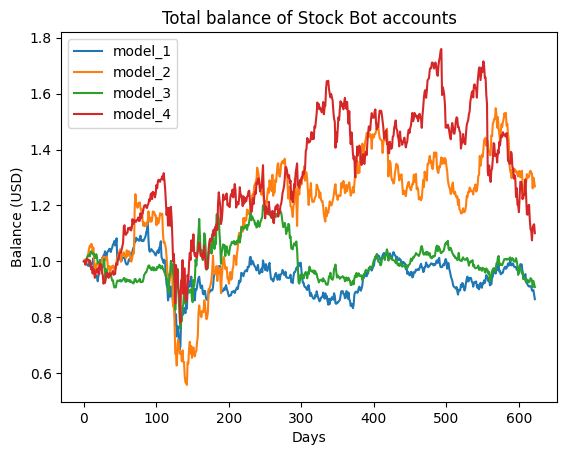

In [ ]:
for balance in balances:
  plt.plot(balance)
plt.title("Total balance of Stock Bot accounts")
plt.ylabel("Balance (USD)")
plt.xlabel("Days")
plt.legend([f"model_{i+1}" for i in range(len(models))])
plt.show()

Final balance for model_1: 0.8641662593607151
Final balance for model_2: 1.2677016314351415
Final balance for model_3: 0.9077997672154683
Final balance for model_4: 1.1004035091317312


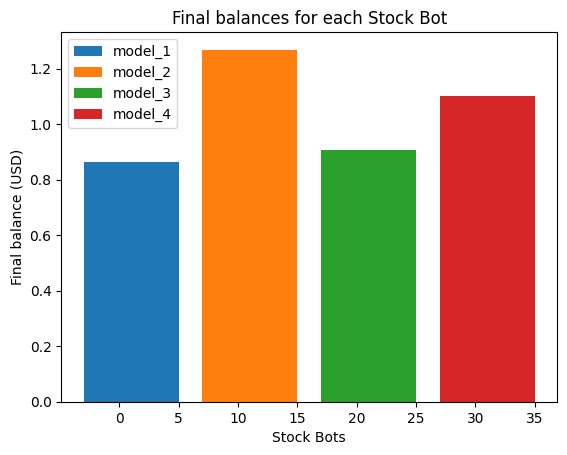

In [ ]:
bar_width = 10
for i, final_balance in enumerate(final_balances):
  print(f"Final balance for model_{i+1}: {final_balance}")
  plt.bar((i+0.1)*bar_width, final_balance, width=0.8*bar_width)
plt.xlabel("Stock Bots")
plt.ylabel("Final balance (USD)")
plt.legend([f"model_{i+1}" for i in range(len(models))])
plt.title("Final balances for each Stock Bot")
plt.show()

Percent return over 623 days for model_1: -13.583374063928488%
Percent return over 623 days for model_2: 26.770163143514146%
Percent return over 623 days for model_3: -9.220023278453171%
Percent return over 623 days for model_4: 10.040350913173125%


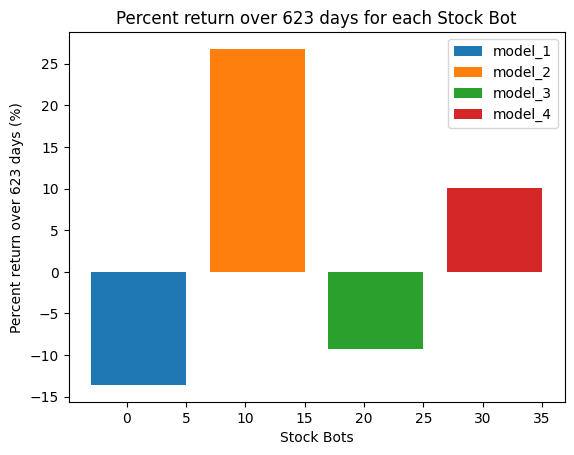

In [ ]:
bar_width = 10
for i, final_balance in enumerate(final_balances):
  print(f"Percent return over 623 days for model_{i+1}: {100*(final_balance-1)}%")
  plt.bar((i+0.1)*bar_width, 100*(final_balance-1), width=0.8*bar_width)
plt.xlabel("Stock Bots")
plt.ylabel("Percent return over 623 days (%)")
plt.legend([f"model_{i+1}" for i in range(len(models))])
plt.title("Percent return over 623 days for each Stock Bot")
plt.show()

Average daily percent return: -0.023430657301259927%
Average daily percent return: 0.038081971956827054%
Average daily percent return: -0.015525511423242211%
Average daily percent return: 0.01535863341419752%


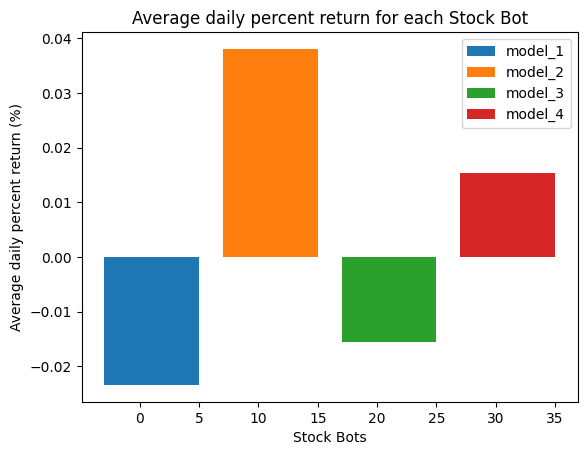

In [ ]:
bar_width = 10
for i, final_balance in enumerate(final_balances):
  print(f"Average daily percent return: {100*(final_balance**(1/x_val.shape[0])-1)}%")
  plt.bar((i+0.1)*bar_width, 100*(final_balance**(1/x_val.shape[0])-1), width=0.8*bar_width)
plt.xlabel("Stock Bots")
plt.ylabel("Average daily percent return (%)")
plt.legend([f"model_{i+1}" for i in range(len(models))])
plt.title("Average daily percent return for each Stock Bot")
plt.show()

Average yearly percent return: -8.197616063023517%
Average yearly percent return: 14.90927724832687%
Average yearly percent return: -5.509654068085201%
Average yearly percent return: 5.765554379536519%


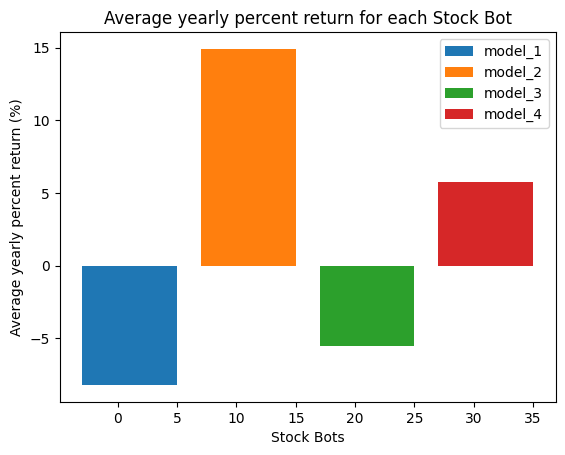

In [ ]:
bar_width = 10
for i, final_balance in enumerate(final_balances):
  print(f"Average yearly percent return: {100*(final_balance**(365/x_val.shape[0])-1)}%")
  plt.bar((i+0.1)*bar_width, 100*(final_balance**(365/x_val.shape[0])-1), width=0.8*bar_width)
plt.xlabel("Stock Bots")
plt.ylabel("Average yearly percent return (%)")
plt.legend([f"model_{i+1}" for i in range(len(models))])
plt.title("Average yearly percent return for each Stock Bot")
plt.show()

Best model: model_3

# Test Best Model (model_3) on Test Set

In [ ]:
best_model = 2 # determined to be the best model based on performance on the validation set

In [ ]:
balance, final_balance = get_balances(models[best_model], x_test, val_idx)

1/1 [==============================] - 0s 15ms/step


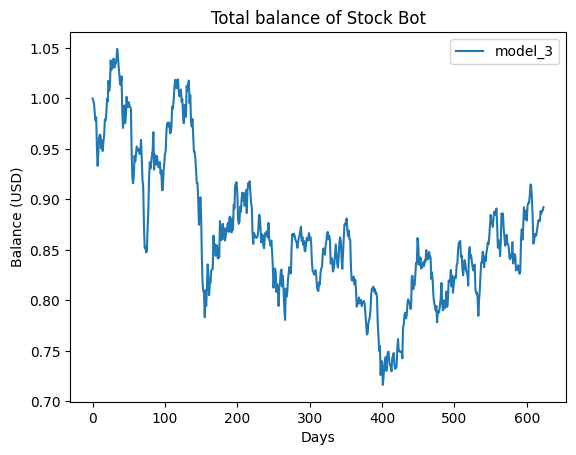

In [ ]:
plt.plot(balance)
plt.title("Total balance of Stock Bot")
plt.ylabel("Balance (USD)")
plt.xlabel("Days")
plt.legend([f"model_{best_model+1}"])
plt.show()

In [ ]:
print(f"Final balance for model_{best_model+1}: {final_balance}")
print(f"Percent return over 623 days for model_{i+1}: {100*(final_balance-1)}%")
print(f"Average daily percent return: {100*(final_balance**(1/x_val.shape[0])-1)}%")
print(f"Average yearly percent return: {100*(final_balance**(365/x_val.shape[0])-1)}%")

Final balance for model_3: 0.8924145325013128
Percent return over 623 days for model_4: -10.758546749868724%
Average daily percent return: -0.018268721405645394%
Average yearly percent return: -6.451196634586043%


In [ ]:
print(companies[invest(models[best_model], x_test[-1])].name) # company that the model recommends investing in today

1/1 [==============================] - 0s 17ms/step
DTE Energy
